# Importing the important libraries

In [1]:
import pandas as pd
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

from pyspark.sql.functions import udf
from pyspark.sql.functions import lower, regexp_replace
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType, DoubleType

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module="scipy")


# Data Pre-processing techniques

# Accessing the dataset

In [2]:
df = pd.read_csv("Tweets.csv")

# Header of dataset

In [3]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


# Columns tag

In [4]:
df = df.iloc[:, 1:]

df.columns = ["id", "date", "flag", "user", "text"]

#df.to_csv("Ready_Tweets.csv", index=False)

In [5]:
df.head()

,id,date,flag,user,text
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [6]:
df['date'].head()

0    Mon Apr 06 22:19:49 PDT 2009
1    Mon Apr 06 22:19:53 PDT 2009
2    Mon Apr 06 22:19:57 PDT 2009
3    Mon Apr 06 22:19:57 PDT 2009
4    Mon Apr 06 22:20:00 PDT 2009
Name: date, dtype: object

In [7]:
# Remove 'PDT' from the 'date' column
df['date'] = df['date'].str.replace('PDT', '', regex=False)


In [8]:
df

,id,date,flag,user,text
0,1467810672,Mon Apr 06 22:19:49 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...
1599994,2193601966,Tue Jun 16 08:40:49 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,2193601969,Tue Jun 16 08:40:49 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,2193601991,Tue Jun 16 08:40:49 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,2193602064,Tue Jun 16 08:40:49 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Sentiment Analysis with TextBlob and Vader using Pyspark and MongoDB

In [9]:
# Create a Spark session
spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()


23/11/10 16:25:15 WARN Utils: Your hostname, College resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/11/10 16:25:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/10 16:25:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
# Define the schema for your data
schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])

# Load the CSV data into a DataFrame
tweets_df = spark.read.csv("Tweets.csv", header=True, schema=schema)


In [11]:
# Create a temporary table for your DataFrame
tweets_df.createOrReplaceTempView("tweets")

In [12]:
# Example: Select top 10 tweets
top_10_tweets = spark.sql("SELECT * FROM tweets LIMIT 10")
top_10_tweets.show()

23/11/10 16:25:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 0, 1467810369, Mon Apr 06 22:19:45 PDT 2009, NO_QUERY, _TheSpecialOne_, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: index, id, date, flag, user, text
Expected: index but found: 0
CSV file: file:///home/muhammad/Downloads/Tweets.csv


+-----+----------+--------------------+--------+---------------+--------------------+
|index|        id|                date|    flag|           user|                text|
+-----+----------+--------------------+--------+---------------+--------------------+
|    1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|    2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|    4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|    5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|    6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|    7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|    8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|    9|1467812025|Mon Apr 06 22:20:...|NO_QUERY|      

In [13]:
total_rows = tweets_df.count()
print("Total rows in the dataset:", total_rows)

Total rows in the dataset: 1599999


In [14]:
tweets_df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [15]:
# Text preprocessing
tweets_df = tweets_df.withColumn("text", lower(tweets_df["text"]))
tweets_df = tweets_df.withColumn("text", regexp_replace(tweets_df["text"], "[^a-zA-Z\\s]", ""))

In [16]:
# Define a UDF to perform sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

sentiment_udf = udf(get_sentiment, DoubleType())
tweets_df = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))

# Show the results
tweets_df.select("text", "sentiment").show()

23/11/10 16:25:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+--------------------+
|                text|           sentiment|
+--------------------+--------------------+
|is upset that he ...|                 0.0|
|kenichan i dived ...|                 0.5|
|my whole body fee...|                 0.2|
|nationwideclass n...|              -0.625|
|kwesidei not the ...|                 0.2|
|         need a hug |                 0.0|
|loltrish hey  lon...|  0.2733333333333333|
|tatianak nope the...|                 0.0|
|twittera que me m...|                 0.0|
|spring break in p...|-0.21428571428571427|
|i just repierced ...|                 0.0|
|caregiving i coul...|                 0.0|
|octolinz it it co...|                 0.0|
|smarrison i would...|               0.075|
|iamjazzyfizzle i ...|                 0.0|
|hollis death scen...|                 0.0|
|about to file taxes |                 0.0|
|lettya ahh ive al...|                 0.5|
|fakerpattypattz o...|                 0.0|
|alydesigns i was ...|          

In [17]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/muhammad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
# Initialize the NLTK SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Define a User Defined Function (UDF) to perform sentiment analysis
def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return "Positive"
    elif sentiment['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

sentiment_udf = udf(analyze_sentiment, StringType())

# Add a new column 'sentiment' to the DataFrame
tweets_df = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))

# Show the results
tweets_df.select("text", "sentiment").show()


23/11/10 16:26:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|is upset that he ...| Negative|
|kenichan i dived ...| Positive|
|my whole body fee...| Negative|
|nationwideclass n...| Negative|
|kwesidei not the ...|  Neutral|
|         need a hug | Positive|
|loltrish hey  lon...| Positive|
|tatianak nope the...|  Neutral|
|twittera que me m...|  Neutral|
|spring break in p...|  Neutral|
|i just repierced ...|  Neutral|
|caregiving i coul...| Negative|
|octolinz it it co...| Negative|
|smarrison i would...| Positive|
|iamjazzyfizzle i ...| Positive|
|hollis death scen...| Negative|
|about to file taxes |  Neutral|
|lettya ahh ive al...| Positive|
|fakerpattypattz o...| Positive|
|alydesigns i was ...|  Neutral|
+--------------------+---------+
only showing top 20 rows



In [19]:
# convert sentiments column into integer
from pyspark.sql.functions import when


sentiment_mapping = {"Positive": 1, "Negative": 2, "Neutral": 0}

# Create a new column 'label' using when and otherwise
tweets_df = tweets_df.withColumn(
    "label",
    when(tweets_df["sentiment"] == "Positive", sentiment_mapping["Positive"])
    .when(tweets_df["sentiment"] == "Negative", sentiment_mapping["Negative"])
    .otherwise(sentiment_mapping["Neutral"])
)


In [20]:
tweets_df.show(n=10);

23/11/10 16:26:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 0, 1467810369, Mon Apr 06 22:19:45 PDT 2009, NO_QUERY, _TheSpecialOne_, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: index, id, date, flag, user, text
Expected: index but found: 0
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+-----+----------+--------------------+--------+---------------+--------------------+---------+-----+
|index|        id|                date|    flag|           user|                text|sentiment|label|
+-----+----------+--------------------+--------+---------------+--------------------+---------+-----+
|    1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...| Negative|    2|
|    2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|kenichan i dived ...| Positive|    1|
|    3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...| Negative|    2|
|    4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|nationwideclass n...| Negative|    2|
|    5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|kwesidei not the ...|  Neutral|    0|
|    6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         need a hug | Positive|    1|
|    7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|loltrish hey  lon.

In [21]:
data_df = tweets_df.select('text','label')
data_df.show()

23/11/10 13:51:42 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+-----+
|                text|label|
+--------------------+-----+
|is upset that he ...|    2|
|kenichan i dived ...|    1|
|my whole body fee...|    2|
|nationwideclass n...|    2|
|kwesidei not the ...|    0|
|         need a hug |    1|
|loltrish hey  lon...|    1|
|tatianak nope the...|    0|
|twittera que me m...|    0|
|spring break in p...|    0|
|i just repierced ...|    0|
|caregiving i coul...|    2|
|octolinz it it co...|    2|
|smarrison i would...|    1|
|iamjazzyfizzle i ...|    1|
|hollis death scen...|    2|
|about to file taxes |    0|
|lettya ahh ive al...|    1|
|fakerpattypattz o...|    1|
|alydesigns i was ...|    0|
+--------------------+-----+
only showing top 20 rows



In [46]:
#Divide data into 70% for training, 30% for testing

(trainingData , testingData) = data_df.randomSplit([0.7, 0.3])

# train_rows = trainingData.count()
# test_rows = testingData.count()

# print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

In [49]:
# Clean the tweets column
def clean_text(text):
    # You can customize this function based on your specific cleaning requirements
    # For now, let's remove mentions, hashtags, and special characters
    cleaned_text = ' '.join([word for word in text.split() if not word.startswith('@') and not word.startswith('#')])
    cleaned_text = ''.join(e for e in cleaned_text if e.isalnum() or e.isspace())
    return cleaned_text

In [50]:
# Register the UDF (clean_text function) with Spark
clean_udf = udf(clean_text, StringType())

In [51]:
trainingData = trainingData.withColumn("text", clean_udf(("text")))

In [52]:
# Separate "tweets" into individual words using tokenizer
tokenizer = Tokenizer(inputCol="text", outputCol="tweetWords")
tokenizedTrain = tokenizer.transform(trainingData)
tokenizedTrain.show(truncate=False, n=5)

23/11/10 10:18:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+-----------------------------+-----+------------------------------------+
|text                         |label|tweetWords                          |
+-----------------------------+-----+------------------------------------+
|exhausted                    |2    |[exhausted]                         |
|i miss her so much already   |2    |[i, miss, her, so, much, already]   |
|rssgreader                   |0    |[rssgreader]                        |
|frustrated                   |2    |[frustrated]                        |
|i missed the new moon trailer|2    |[i, missed, the, new, moon, trailer]|
+-----------------------------+-----+------------------------------------+
only showing top 5 rows



In [53]:
# Removing stop words (unimportant words to be features)
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(),
                       outputCol="MeaningfulWords")
SwRemovedTrain = swr.transform(tokenizedTrain)


23/11/10 10:21:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+---------+-----+-----------+---------------+
|text     |label|tweetWords |MeaningfulWords|
+---------+-----+-----------+---------------+
|exhausted|2    |[exhausted]|[exhausted]    |
+---------+-----+-----------+---------------+
only showing top 1 row



In [55]:
SwRemovedTrain.show(truncate=False, n=5);

23/11/10 10:25:50 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv


+-----------------------------+-----+------------------------------------+----------------------------+
|text                         |label|tweetWords                          |MeaningfulWords             |
+-----------------------------+-----+------------------------------------+----------------------------+
|exhausted                    |2    |[exhausted]                         |[exhausted]                 |
|i miss her so much already   |2    |[i, miss, her, so, much, already]   |[miss, much, already]       |
|rssgreader                   |0    |[rssgreader]                        |[rssgreader]                |
|frustrated                   |2    |[frustrated]                        |[frustrated]                |
|i missed the new moon trailer|2    |[i, missed, the, new, moon, trailer]|[missed, new, moon, trailer]|
+-----------------------------+-----+------------------------------------+----------------------------+
only showing top 5 rows



In [56]:
# Converting words feature into numerical feature withHashingTF funtion for model training
hashTF = HashingTF(inputCol=swr.getOutputCol(), outputCol="features")
numericTrainData = hashTF.transform(SwRemovedTrain).select(
    'label', 'MeaningfulWords', 'features')


In [57]:
numericTrainData.show(truncate=False, n=3);

23/11/10 10:28:34 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv


+-----+---------------------+------------------------------------------+
|label|MeaningfulWords      |features                                  |
+-----+---------------------+------------------------------------------+
|2    |[exhausted]          |(262144,[148003],[1.0])                   |
|2    |[miss, much, already]|(262144,[2306,76764,232735],[1.0,1.0,1.0])|
|0    |[rssgreader]         |(262144,[90369],[1.0])                    |
+-----+---------------------+------------------------------------------+
only showing top 3 rows



In [58]:
train_data = numericTrainData.select('features','label')

In [59]:
# Train our classifier model using training data

lr = LogisticRegression(featuresCol="features", labelCol="label",
                        maxIter=10, regParam=0.01)
model = lr.fit(numericTrainData)
print ("Training is done!")

23/11/10 10:31:18 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
23/11/10 10:34:35 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of

Training is done!


In [60]:
# apply clean function to testing tweets
testingData = testingData.withColumn("text", clean_udf(("text")))

In [61]:
# Prepare testing data
tokenizedTest = tokenizer.transform(testingData)
SwRemovedTest = swr.transform(tokenizedTest)
numericTest = hashTF.transform(SwRemovedTest).select(
    'Label', 'MeaningfulWords', 'features')
numericTest.show(truncate=False, n=2)

23/11/10 11:00:36 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+-----+-------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|Label|MeaningfulWords                                                          |features                                                                                                   |
+-----+-------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|2    |[transit, heddesheim, de, ltlt, guess, car, accident, involving, sandals]|(262144,[43265,48207,71578,84360,112980,141836,183729,189716,189826],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|0    |[sad, apl, friend]                                                       |(262144,[74520,74989,125638],[1.0,1.0,1.0])                                                                |
+-----+-------------------------------------------

In [62]:
# Predict testing data and calculate the accuracy model
prediction = model.transform(numericTest)
predictionFinal = prediction.select(
    "MeaningfulWords", "prediction", "Label")
predictionFinal.show(n=4, truncate = False)
correctPrediction = predictionFinal.filter(
    predictionFinal['prediction'] == predictionFinal['Label']).count()
totalData = predictionFinal.count()
print("correct prediction:", correctPrediction, ", total data:", totalData,
      ", accuracy:", correctPrediction/totalData)

23/11/10 11:03:10 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
23/11/10 11:03:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv


+-------------------------------------------------------------------------+----------+-----+
|MeaningfulWords                                                          |prediction|Label|
+-------------------------------------------------------------------------+----------+-----+
|[transit, heddesheim, de, ltlt, guess, car, accident, involving, sandals]|2.0       |2    |
|[sad, apl, friend]                                                       |2.0       |0    |
|[podmarathon]                                                            |0.0       |0    |
|[nearby]                                                                 |0.0       |0    |
+-------------------------------------------------------------------------+----------+-----+
only showing top 4 rows



23/11/10 11:04:51 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
23/11/10 11:04:51 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
23/11/10 11:07:20 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switc

correct prediction: 394775 , total data: 479785 , accuracy: 0.8228164698771324


# MongoDB to use the access and save the dataset

In [21]:
# Initialize a connection to MongoDB (adjust the connection string as needed)
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["twitter_data"]
collection = db["tweets"]

In [22]:
tweets_df_panda = tweets_df.toPandas()

23/11/10 16:27:09 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 0, 1467810369, Mon Apr 06 22:19:45 PDT 2009, NO_QUERY, _TheSpecialOne_, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: index, id, date, flag, user, text
Expected: index but found: 0
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [25]:
data = tweets_df_panda.to_csv("Sentiments_data.csv", index=False)

In [2]:
sentiment_df = pd.read_csv('Sentiments_data.csv')

In [7]:
# Convert the DataFrame to a list of dictionaries for insertion into MongoDB
tweets = sentiment_df.to_dict(orient="records")

In [14]:
tweets[750]

{'index': 751,
 'id': 1467998601.0,
 'date': 'Mon Apr 06 23:11:18 PDT 2009',
 'flag': 'NO_QUERY',
 'user': 'Young_J',
 'text': 'im off too bed i gotta wake up hella early tomorrow morning ',
 'sentiment': 'Neutral',
 'label': 0}

In [9]:
total_tweets = len(tweets)
print("Total rows in the dataset:", total_tweets)

Total rows in the dataset: 1599999


In [29]:
# Insert the data into the MongoDB collection
collection.insert_many(tweets)

In [7]:
# Retrieve the data from the MongoDB collection
data = list(collection.find())

ServerSelectionTimeoutError: localhost:27017: [Errno 111] Connection refused, Timeout: 30s, Topology Description: <TopologyDescription id: 654e583d9eafb036e9d79480, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused')>]>

In [ ]:
# Analyze sentiment for each tweet
for tweet in tweets:
    text = tweet["text"]
    analysis = TextBlob(text)
    tweet["sentiment_polarity"] = analysis.sentiment.polarity
    tweet["sentiment_subjectivity"] = analysis.sentiment.subjectivity


In [24]:
for tweet in tweets:
    collection.update_one(
        {"id": tweet["id"]},  # Use a unique identifier (e.g., "_id" field)
        {"$set": {"sentiment_polarity": tweet["sentiment_polarity"], "sentiment_subjectivity": tweet["sentiment_subjectivity"]}}
    )


In [3]:
# Retrieve a few updated results
results = list(collection.find().limit(5))  # Adjust the limit as needed

# Display the updated results
for result in results:
    print(f"Tweet: {result['text']}")
    print(f"Sentiment Polarity: {result['sentiment_polarity']}")
    print(f"Sentiment Subjectivity: {result['sentiment_subjectivity']}")
    print("--------------")

ServerSelectionTimeoutError: localhost:27017: [Errno 111] Connection refused, Timeout: 30s, Topology Description: <TopologyDescription id: 654e57889eafb036e9d7947f, topology_type: Unknown, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 111] Connection refused')>]>

In [ ]:
# Create a DataFrame from the list of dictionaries
new_df = pd.DataFrame(tweets)

In [10]:
df_data = new_df.to_csv("Time_Series_data.csv", index=False)

NameError: name 'new_df' is not defined

In [3]:
time_df = pd.read_csv("Time_Series_data.csv")

In [4]:
time_df

,id,date,flag,user,text,sentiment_polarity,sentiment_subjectivity
0,1467810672,Mon Apr 06 22:19:49 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0.000,0.0000
1,1467810917,Mon Apr 06 22:19:53 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0.500,0.5000
2,1467811184,Mon Apr 06 22:19:57 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0.200,0.4000
3,1467811193,Mon Apr 06 22:19:57 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",-0.625,1.0000
4,1467811372,Mon Apr 06 22:20:00 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,0.200,0.4000
...,...,...,...,...,...,...,...
1599994,2193601966,Tue Jun 16 08:40:49 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,1.000,0.3000
1599995,2193601969,Tue Jun 16 08:40:49 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,0.290,0.5225
1599996,2193601991,Tue Jun 16 08:40:49 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,0.200,0.5000
1599997,2193602064,Tue Jun 16 08:40:49 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,1.000,1.0000


In [5]:
sentiment_df['id'] = time_df['id']

In [6]:
# Select the relevant columns from each DataFrame
df1_subset = time_df[['id', 'date', 'flag', 'user', 'text', 'sentiment_polarity', 'sentiment_subjectivity']]
df2_subset = sentiment_df[['id', 'date', 'flag', 'user', 'text', 'sentiment', 'label']]

In [7]:
# Merge the DataFrames on the 'id' column
merged_df = pd.merge(df1_subset, df2_subset, on='id')

In [8]:
merged_df

,id,date_x,flag_x,user_x,text_x,sentiment_polarity,sentiment_subjectivity,date_y,flag_y,user_y,text_y,sentiment,label
0,1467810672,Mon Apr 06 22:19:49 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0.000,0.0000,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he cant update his facebook by t...,Negative,2
1,1467810917,Mon Apr 06 22:19:53 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0.500,0.5000,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,kenichan i dived many times for the ball manag...,Positive,1
2,1467811184,Mon Apr 06 22:19:57 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0.200,0.4000,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,2
3,1467811193,Mon Apr 06 22:19:57 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",-0.625,1.0000,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,nationwideclass no its not behaving at all im ...,Negative,2
4,1467811372,Mon Apr 06 22:20:00 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,0.200,0.4000,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,kwesidei not the whole crew,Neutral,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603364,2193601966,Tue Jun 16 08:40:49 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,1.000,0.3000,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,just woke up having no school is the best feel...,Positive,1
1603365,2193601969,Tue Jun 16 08:40:49 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,0.290,0.5225,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdbcom very cool to hear old walt intervie...,Positive,1
1603366,2193601991,Tue Jun 16 08:40:49 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,0.200,0.5000,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,are you ready for your mojo makeover ask me fo...,Positive,1
1603367,2193602064,Tue Jun 16 08:40:49 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,1.000,1.0000,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy th birthday to my boo of alll time tupac...,Positive,1


In [9]:
# Drop unnecessary columns and reset the index
merged_df = merged_df[['id', 'date_x', 'flag_x', 'user_x', 'text_x', 'sentiment', 'label', 'sentiment_polarity', 'sentiment_subjectivity']]
merged_df = merged_df.rename(columns={'date_x': 'date', 'flag_x': 'flag', 'user_x': 'user', 'text_x': 'text'})
merged_df = merged_df.set_index('id')

In [11]:
# Assuming "date" is in datetime format, set it as the DataFrame's index
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df.set_index('date', inplace=True)

In [12]:
merged_df

,flag,user,text,sentiment,label,sentiment_polarity,sentiment_subjectivity
date,,,,,,,
2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Negative,2,0.000,0.0000
2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Positive,1,0.500,0.5000
2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Negative,2,0.200,0.4000
2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Negative,2,-0.625,1.0000
2009-04-06 22:20:00,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,Neutral,0,0.200,0.4000
...,...,...,...,...,...,...,...
2009-06-16 08:40:49,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,Positive,1,1.000,0.3000
2009-06-16 08:40:49,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,Positive,1,0.290,0.5225
2009-06-16 08:40:49,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,Positive,1,0.200,0.5000


In [22]:
#merged_df.to_csv("final_dataset.csv")

In [4]:
merged_df = pd.read_csv("final_dataset.csv")

In [5]:
def clean_tweet(tweet):
    # Remove links
    tweet = re.sub(r'http\S+', '', tweet)

    # Remove words starting with '@' (user mentions)
    tweet = re.sub(r'@\S+', '', tweet)

    # Remove special characters and numbers
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    return tweet

In [6]:
# Apply the cleaning function to the 'tweets' column
merged_df['text'] = merged_df['text'].apply(clean_tweet)

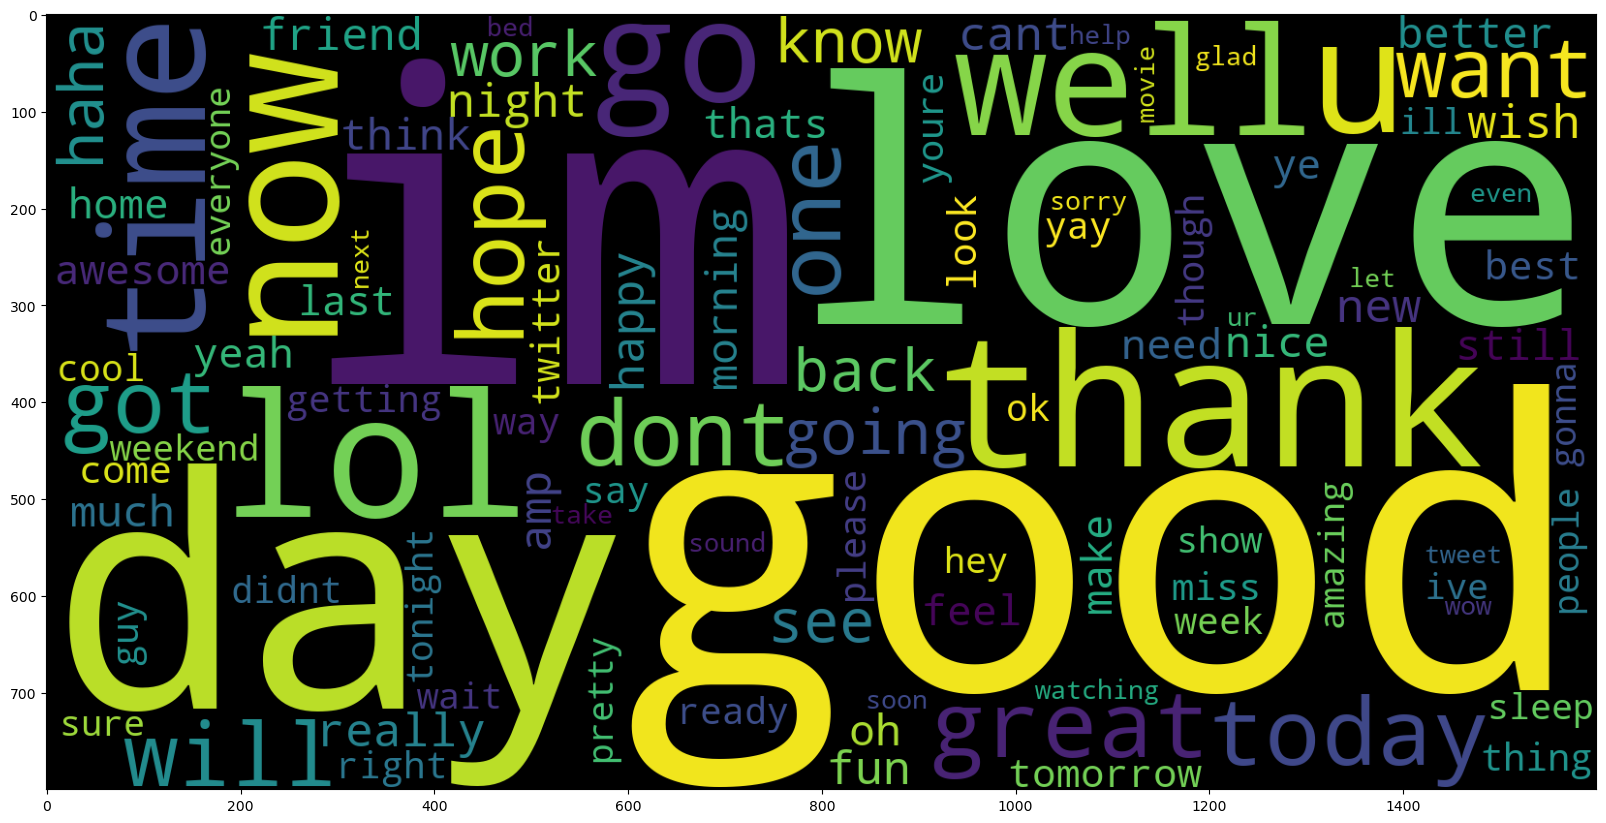

In [9]:
# Word-Cloud for positive tweets.
filt = (merged_df['sentiment'] == 'Positive')
data_pos = merged_df['text'][filt]
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

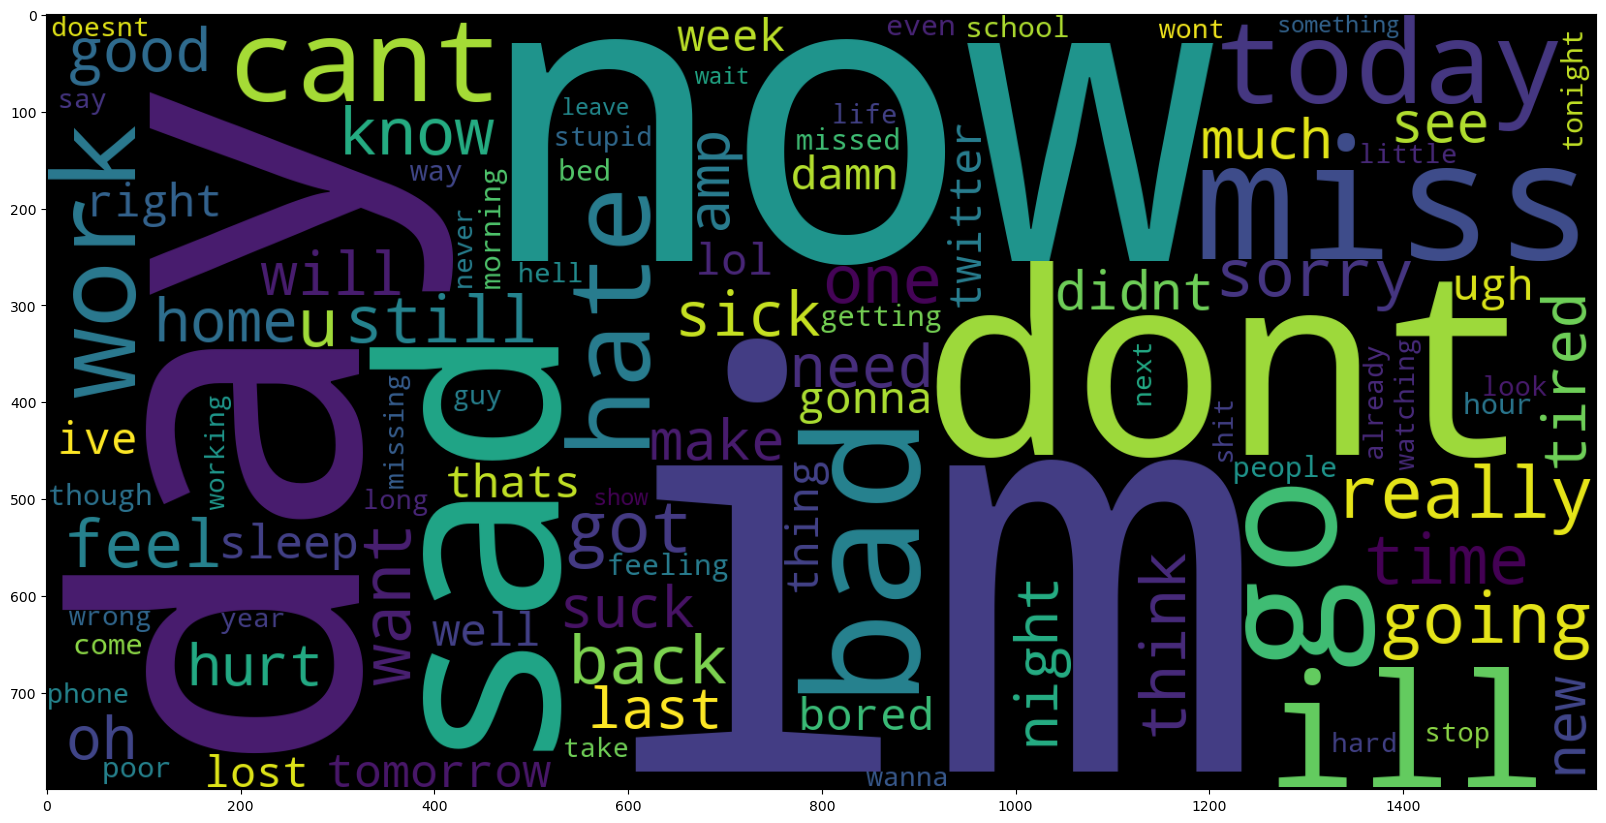

In [31]:
# Word-Cloud for negative tweets.
filt = (merged_df['sentiment'] == 'Negative')
data_pos = merged_df['text'][filt]
wc = WordCloud(max_words = 100 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(merged_df['text'], merged_df['label'],
                                                    test_size = 0.2, random_state = 0)

In [33]:
# Create and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)

In [34]:
# Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

X_train = vectorizer.fit_transform(X_train)
X_test  = vectorizer.fit_transform(X_test)
print(f'Data Transformed')

Data Transformed


In [35]:
from sklearn.metrics import confusion_matrix, classification_report

def model_Evaluate(model):
    # Predict values for the Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories = ['Neutral', 'Negative', 'Positive']

    # Plot the confusion matrix using seaborn
    sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted values")
    plt.ylabel("Actual values")
    plt.show()



              precision    recall  f1-score   support

           0       0.53      0.50      0.51     87245
           1       0.62      0.60      0.61    148305
           2       0.38      0.43      0.40     85124

    accuracy                           0.53    320674
   macro avg       0.51      0.51      0.51    320674
weighted avg       0.53      0.53      0.53    320674



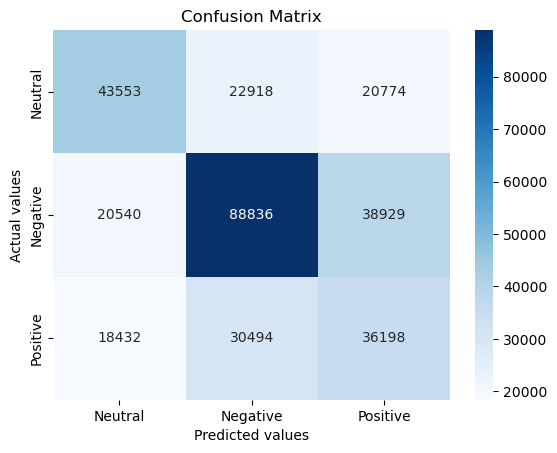

In [36]:
# Bernouli Model
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.42      0.61      0.50     87245
           1       0.62      0.50      0.55    148305
           2       0.36      0.31      0.33     85124

    accuracy                           0.48    320674
   macro avg       0.46      0.47      0.46    320674
weighted avg       0.49      0.48      0.48    320674



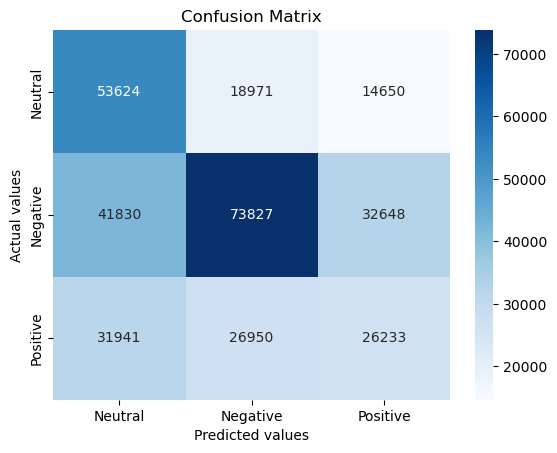

In [37]:
# Support Vector Machine model
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.42      0.62      0.50     87245
           1       0.62      0.50      0.55    148305
           2       0.36      0.30      0.33     85124

    accuracy                           0.48    320674
   macro avg       0.46      0.47      0.46    320674
weighted avg       0.49      0.48      0.48    320674



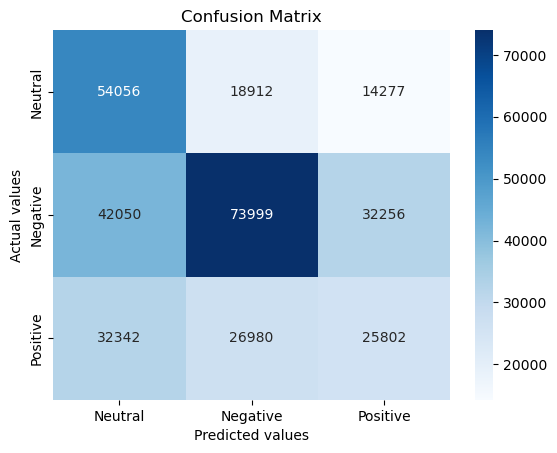

In [38]:
# Linear Regression model
lrmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
lrmodel.fit(X_train, y_train)
model_Evaluate(lrmodel)

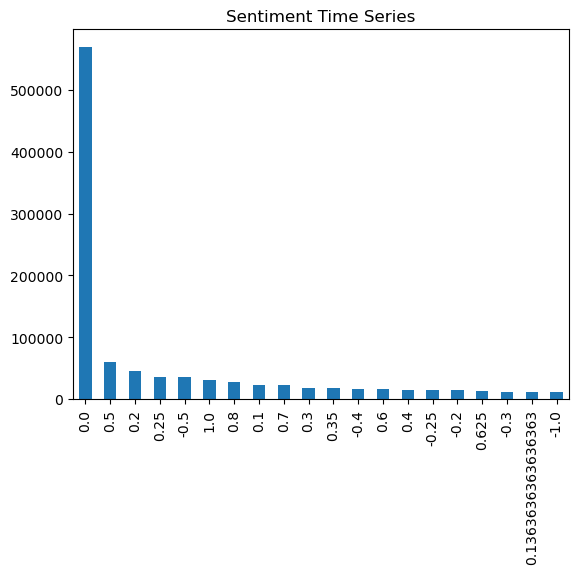

In [17]:
merged_df['sentiment_polarity'].value_counts().iloc[:20].plot(title='Sentiment Time Series', kind='bar')
plt.show()

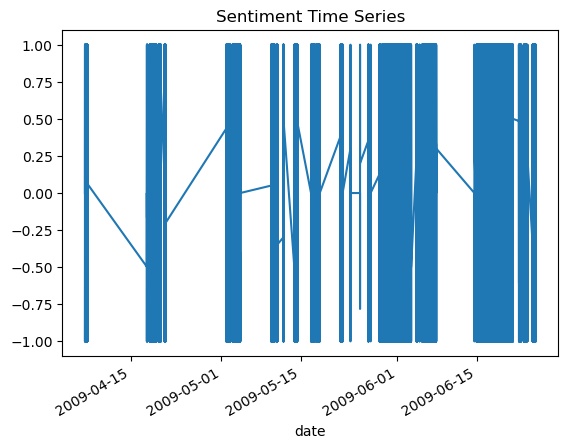

In [18]:
# Create a time series plot to visualize the sentiment data
merged_df['sentiment_polarity'].plot(title='Sentiment Time Series')
plt.show()

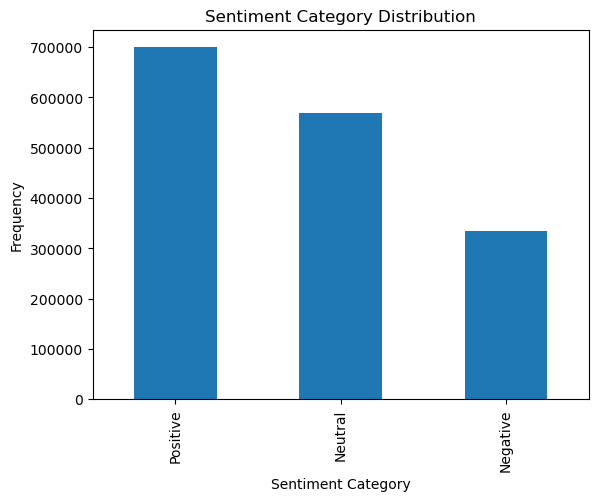

In [20]:
# Categorize sentiment scores
merged_df['sentiment_category'] = np.where(merged_df['sentiment_polarity'] > 0, 'Positive',
                                      np.where(merged_df['sentiment_polarity'] < 0, 'Negative', 'Neutral'))

# Create a bar plot
merged_df['sentiment_category'].value_counts().plot(kind='bar')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.show()


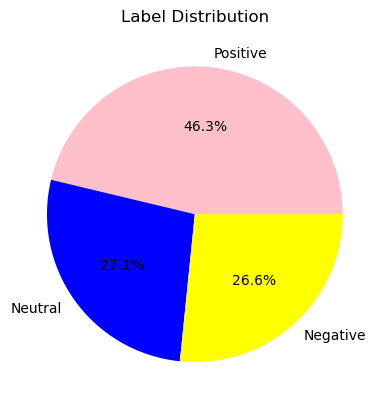

In [39]:
# Alternatively, create a pie chart
label_counts = merged_df['sentiment'].value_counts()
label_counts.plot(kind='pie', autopct='%1.1f%%', colors=['pink', 'blue', 'yellow'])
plt.title('Label Distribution')
plt.ylabel('')
plt.show()

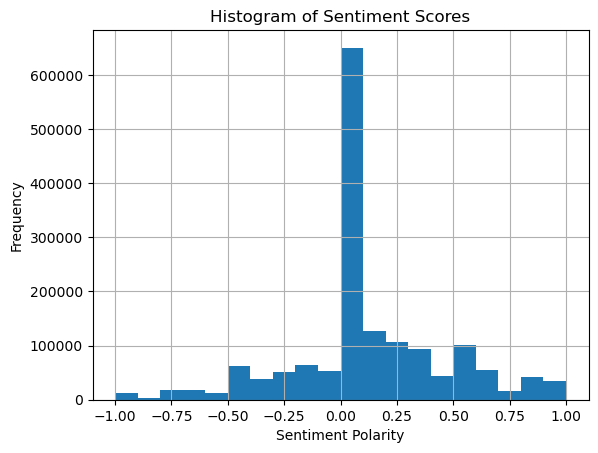

In [21]:
merged_df['sentiment_polarity'].hist(bins=20)
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Time Forecasting 1 week, 1 month, 3 months

# ARIMA and Exponential Smoothing

In [11]:
# Define the time periods for forecasting
forecast_periods = [7, 30, 90]  # 1 week, 1 month, 3 months

In [12]:
# Perform forecasting and store the results
forecast_results = {
    'ARIMA': [],
    'Exponential Smoothing': []
}

In [13]:
for period in forecast_periods:
    # ARIMA Forecasting
    arima_model = ARIMA(time_df['sentiment_polarity'], order=(5, 1, 0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=period)

    # Exponential Smoothing (Holt-Winters) Forecasting
    exp_model = ExponentialSmoothing(time_df['sentiment_polarity'], trend='add', seasonal='add', seasonal_periods=7)
    exp_fit = exp_model.fit()
    exp_forecast = exp_fit.forecast(steps=period)

    forecast_results['ARIMA'].append(arima_forecast)
    forecast_results['Exponential Smoothing'].append(exp_forecast)



Forecasts for 7 days:
ARIMA Forecast: 1599999    0.649390
1600000    0.655967
1600001    0.599182
1600002    0.651891
1600003    0.725502
1600004    0.680089
1600005    0.660458
Name: predicted_mean, dtype: float64
Exponential Smoothing Forecast: 1599999    0.203609
1600000    0.255950
1600001    0.230816
1600002    0.332968
1600003    0.151521
1600004    0.229270
1600005    0.226438
dtype: float64



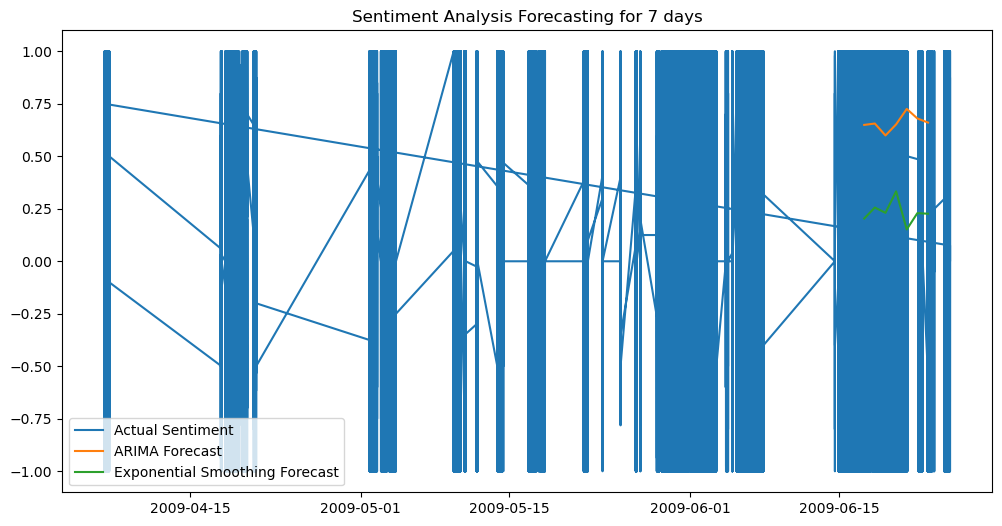

Forecasts for 30 days:
ARIMA Forecast: 1599999    0.649390
1600000    0.655967
1600001    0.599182
1600002    0.651891
1600003    0.725502
1600004    0.680089
1600005    0.660458
1600006    0.662150
1600007    0.663277
1600008    0.673973
1600009    0.677480
1600010    0.669556
1600011    0.667836
1600012    0.669049
1600013    0.670205
1600014    0.671350
1600015    0.670900
1600016    0.669817
1600017    0.669863
1600018    0.670198
1600019    0.670389
1600020    0.670418
1600021    0.670263
1600022    0.670159
1600023    0.670216
1600024    0.670274
1600025    0.670286
1600026    0.670269
1600027    0.670244
1600028    0.670241
Name: predicted_mean, dtype: float64
Exponential Smoothing Forecast: 1599999    0.203609
1600000    0.255950
1600001    0.230816
1600002    0.332968
1600003    0.151521
1600004    0.229270
1600005    0.226438
1600006    0.203901
1600007    0.256242
1600008    0.231109
1600009    0.333261
1600010    0.151814
1600011    0.229563
1600012    0.226730
1600013    0

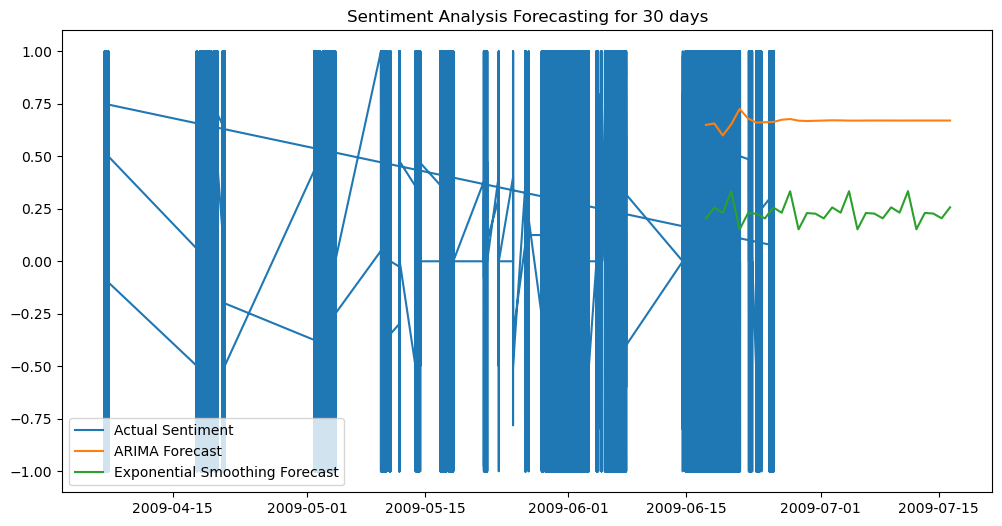

Forecasts for 90 days:
ARIMA Forecast: 1599999    0.649390
1600000    0.655967
1600001    0.599182
1600002    0.651891
1600003    0.725502
             ...   
1600084    0.670256
1600085    0.670256
1600086    0.670256
1600087    0.670256
1600088    0.670256
Name: predicted_mean, Length: 90, dtype: float64
Exponential Smoothing Forecast: 1599999    0.203609
1600000    0.255950
1600001    0.230816
1600002    0.332968
1600003    0.151521
             ...   
1600084    0.259458
1600085    0.234324
1600086    0.336476
1600087    0.155029
1600088    0.232778
Length: 90, dtype: float64



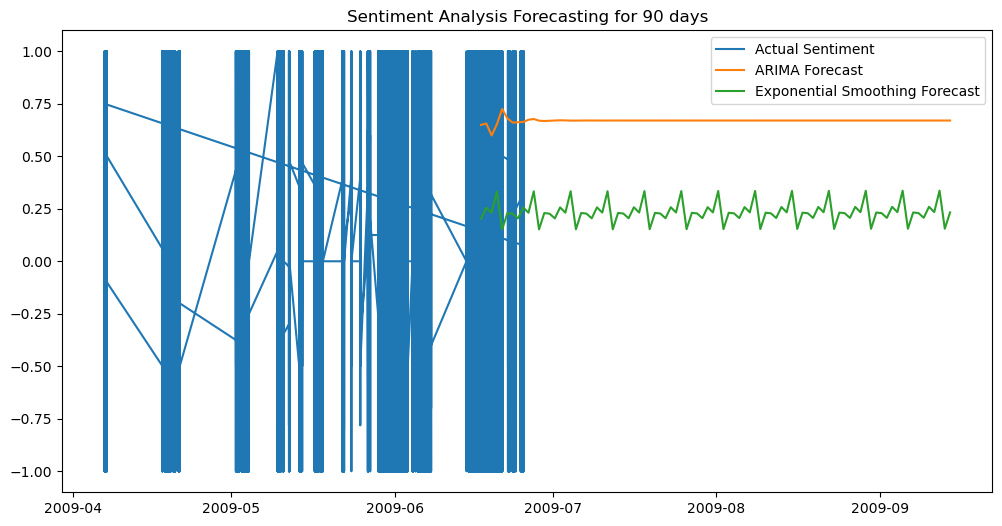

In [14]:
# Print and visualize the forecasts
for i, period in enumerate(forecast_periods):
    print(f"Forecasts for {period} days:")
    print(f"ARIMA Forecast: {forecast_results['ARIMA'][i]}")
    print(f"Exponential Smoothing Forecast: {forecast_results['Exponential Smoothing'][i]}")
    print()

    plt.figure(figsize=(12, 6))
    plt.plot(time_df.index, time_df['sentiment_polarity'], label='Actual Sentiment')
    plt.plot(pd.date_range(start=time_df.index[-1], periods=period + 1, closed='right'), forecast_results['ARIMA'][i], label='ARIMA Forecast')
    plt.plot(pd.date_range(start=time_df.index[-1], periods=period + 1, closed='right'), forecast_results['Exponential Smoothing'][i], label='Exponential Smoothing Forecast')
    plt.legend()
    plt.title(f'Sentiment Analysis Forecasting for {period} days')
    plt.show()

In [41]:
# Split the data into a training set and a testing set
train_size = int(len(time_df) * 0.8)
train, test = time_df[:train_size], time_df[train_size:]

In [43]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['sentiment_polarity']])
test_scaled = scaler.transform(test[['sentiment_polarity']])


In [47]:
# Create sequences for the LSTM model
def create_sequences(time_df, sequence_length):
    X, y = [], []
    for i in range(len(time_df) - sequence_length):
        X.append(time_df[i:i+sequence_length])
        y.append(time_df[i+sequence_length])
    return np.array(X), np.array(y)

In [48]:
sequence_length = 10  # You can adjust this based on your dataset and needs
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [49]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
20000/20000 [==============================] - 117s 6ms/step - loss: 0.0294
Epoch 2/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.0293
Epoch 3/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.0292
Epoch 4/10
20000/20000 [==============================] - 120s 6ms/step - loss: 0.0292
Epoch 5/10
20000/20000 [==============================] - 125s 6ms/step - loss: 0.0292
Epoch 6/10
20000/20000 [==============================] - 120s 6ms/step - loss: 0.0292
Epoch 7/10
20000/20000 [==============================] - 117s 6ms/step - loss: 0.0292
Epoch 8/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.0292
Epoch 9/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.0292
Epoch 10/10
20000/20000 [==============================] - 126s 6ms/step - loss: 0.0292


In [53]:
# Make predictions
y_pred = model.predict(X_test)

10000/10000 [==============================] - 17s 2ms/step


In [54]:
# Inverse transform the scaled predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [55]:
# Calculate the Mean Squared Error (MSE) for the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 0.11405823296478992


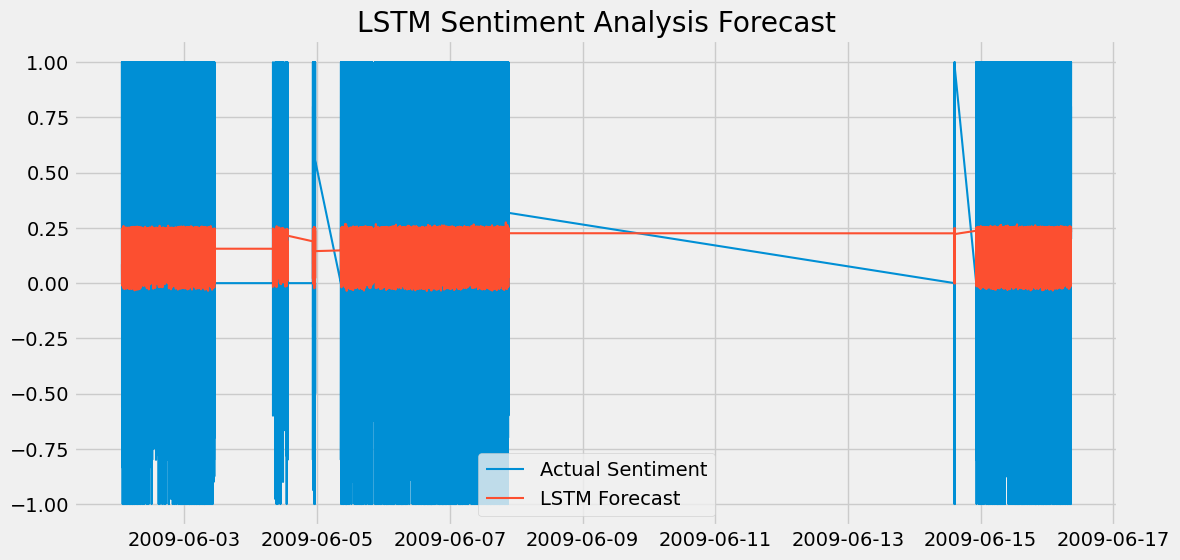

In [56]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[sequence_length:], y_test, label='Actual Sentiment')
plt.plot(test.index[sequence_length:], y_pred, label='LSTM Forecast')
plt.legend()
plt.title('LSTM Sentiment Analysis Forecast')
plt.show()

In [10]:
import plotly.graph_objects as go
from ipywidgets import interact

# Assuming 'merged_df' is your DataFrame with 'date' and 'sentiment' columns
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df.set_index('date')

# Create an interactive dashboard
def update_dashboard(period):
    # Filter the data based on the selected time period
    if period == '1 week':
        filtered_data = merged_df.last('1W')
    elif period == '1 month':
        filtered_data = merged_df.last('1M')
    elif period == '3 months':
        filtered_data = merged_df.last('3M')
    else:
        filtered_data = merged_df  # Show all data for 'All'

    # Plot the sentiment over time
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['sentiment'], mode='lines', name='Sentiment'))
    fig.update_layout(title=f'Sentiment Over Time ({period})', xaxis_title='Date', yaxis_title='Sentiment')
    fig.show()

# Define a list of time periods
time_periods = ['1 week', '1 month', '3 months', 'All']

# Create an interactive widget for selecting the time period
interact(update_dashboard, period=time_periods)


interactive(children=(Dropdown(description='period', options=('1 week', '1 month', '3 months', 'All'), value='…

<function __main__.update_dashboard(period)>

# Closing Connection MongoDB and Spark

In [4]:
# Close the MongoDB connection
client.close()

In [6]:
spark.stop()